## set-up

In [ ]:
import cv2
import subprocess
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.cluster import KMeans
from matplotlib import cm
from skimage.transform import probabilistic_hough_line
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.draw import line as draw_line
from skimage.morphology import skeletonize, thin, opening, square
from skimage.filters import gaussian
from skimage import data

## loading test image
Please notice that there are different loading methods depending on the type of images from study 2 (with white backgrounds) and study 3 (with transparent backgrounds). Below, we are working with an example from study 3

In [49]:
# setting up paths

# getting local root of GitHub repository
repo_root = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())

# specify drawing_sample folder
drawing_samples = repo_root / 'drawing_samples'

# specify study
study = 'STUDY3_drawing_samples'

# specify a file name from that study folder
file_name = 'Communication_Chain1_Seed2_Gen9.png'

# we can now assemble the path
file_path = str(drawing_samples / study / file_name)

In [ ]:
# ======= When working with data from study 2, use this chunk – commented out for now ========

# # for png with white background
# test_img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# # converting to binary
# _, img_bin = cv2.threshold(test_img, 127, 1, cv2.THRESH_BINARY_INV)

# plt.imshow(img_bin, cmap='gray')

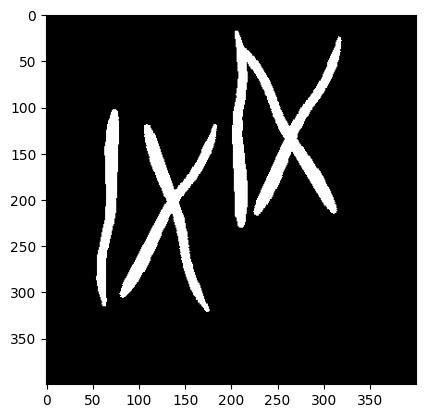

In [61]:
# ======= When working with data from study 3 (with transparent background), use this chunk ========
img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

# split channels
b, g, r, a = cv2.split(img)

# convert to greyscale; convert transparent pixels to white
gray = cv2.cvtColor(cv2.merge([b, g, r]), cv2.COLOR_BGR2GRAY)
gray[a == 0] = 255

# binarize
_, img_bin = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV)

plt.imshow(img_bin, cmap='gray')

## Step 1: Fitting line elements within each line via Probabilistic Hough Transform
Documentation: https://scikit-image.org/docs/0.25.x/auto_examples/edges/plot_line_hough_transform.html

Please note that the results are very sensitive to how the parameters of the probabilistic_hough_line() are set. The current combination was reached through trial and error but the accuracy of this setting has not been assessed systematically yet.

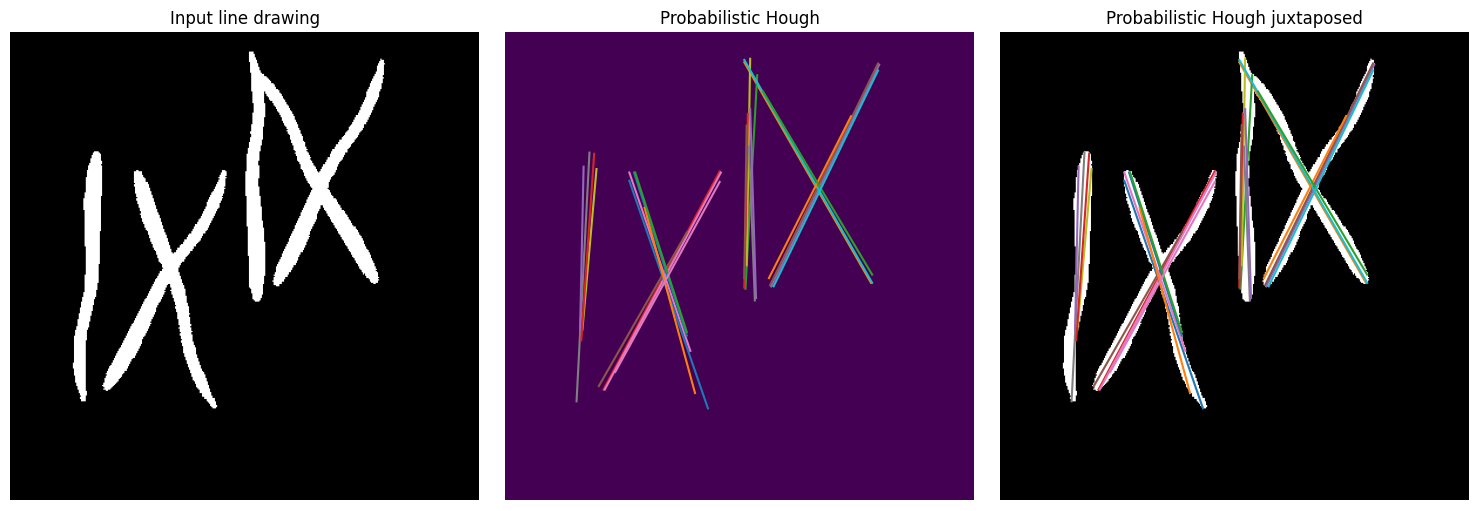

In [63]:
# Line finding using the Probabilistic Hough Transform
image = img_bin
lines = probabilistic_hough_line(image, 
                                 threshold=30, 
                                 line_length=130, 
                                 line_gap=2)

# plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input line drawing')

ax[1].imshow(image * 0)
for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[1].set_xlim((0, image.shape[1]))
ax[1].set_ylim((image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

ax[2].imshow(image, cmap=cm.gray)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image.shape[1]))
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_title('Probabilistic Hough juxtaposed')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

All lines are covered with line segments from start to finish. The next step would be to find a single 'average' line from these line segments, that can cover each actual line from origin to end point.

## Step 2: Representing each line as midpoints and orientations

Here, some features of all sublines are computed and stored as a new data structure. 

The idea is to be able to cluster the linesegments within each actual line based on their midpoints and orientations, following the rationale that sublines with very similar midpoints and orientations will belong to the same actual line.

In [64]:
# writing midpoint function
def find_midpoint(line_segment):

    x_1 = line_segment[0][0]
    y_1 = line_segment[0][1]
    x_2 = line_segment[1][0]
    y_2 = line_segment[1][1]
    
    midpoint = [(x_1+x_2)/2,(y_1+y_2)/2]

    return midpoint

In [66]:
# writing orientation function
def find_orientation(line_segment):

    x_1 = line_segment[0][0]
    y_1 = line_segment[0][1]
    x_2 = line_segment[1][0]
    y_2 = line_segment[1][1]

    # dx = x_2 - x_1
    # dy = y_2 - y_1
    # angle = np.arctan2(dy, dx)

    # first we compute the slope - this gives div by 0 issues...
    if x_2 == x_1:
        slope = np.inf  # dealing with vertical lines
    else:    
        slope = (y_2-y_1) / (x_2-x_1)

    # then we find the angle using arctan - they should maybe be 'standardized' to make opposite vectors the same (see BTL script for approach...)
    orientation = math.atan(slope) 

    return orientation


In [67]:
# making new line representations
line_tupples = []

for line_segment in lines:
    midpoint = find_midpoint(line_segment)
    orientation = find_orientation(line_segment)
    representation = {'x': midpoint[0], 'y': midpoint[1], 'orientation': orientation}
    
    # adding the representation to the new data frame
    line_tupples.append(representation)

# converting to a dataframe
lines_df = pd.DataFrame(line_tupples)

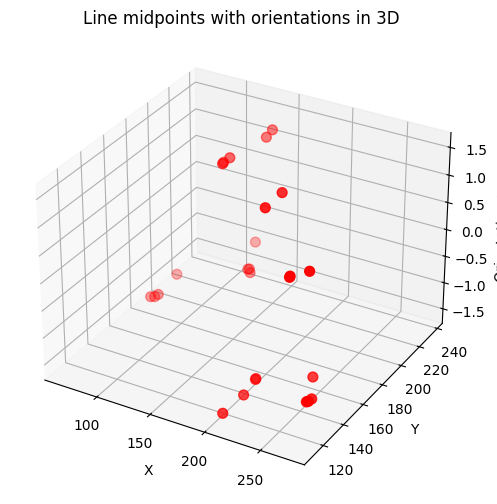

In [68]:
# plotting the data to see visually if clusters occur
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

df = lines_df

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x'], df['y'], df['orientation'], c='red', s=50)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Orientation (rad)')
ax.set_title('Line midpoints with orientations in 3D')

plt.show()

## Step 3: Clustering (labelling) sublines

This part of the script is still very much a work in progress. The idea is to use clustering algorithms to group the lines. Immediate results seem very mixed.

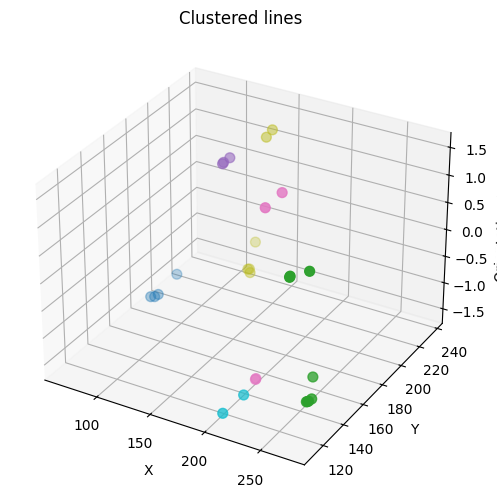

In [69]:
# clustering the lines using KMeans
kmeans = KMeans(init="k-means++", n_clusters=6, n_init=300)
kmeans.fit(lines_df)

kmeans.cluster_centers_
kmeans.labels_

# adding the clustering information to a new line dataframe
clustered_lines = lines_df
clustered_lines['cluster_labels'] = kmeans.labels_[:]

# plotting the lines colored by label
df = clustered_lines

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x'], df['y'], df['orientation'], c=df['cluster_labels'], cmap='tab10', s=50)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Orientation (rad)')
ax.set_title('Clustered lines')

plt.show()

It could be a one-time luck kind of thing, but it actually seems stable for some inputs (such as: '/Users/christianstenbro/AU/eSYMb/structural_analysis_project/test_drawing_base64_export/con1_chain5_subchain1_1.png')

We need to try to plot the lines again, this time with their label color...

In [33]:
lines

[((159, 312), (103, 118)),
 ((301, 252), (200, 61)),
 ((80, 315), (172, 126)),
 ((159, 311), (104, 119)),
 ((83, 318), (171, 137)),
 ((291, 244), (199, 48)),
 ((200, 260), (207, 61)),
 ((70, 314), (66, 107)),
 ((198, 259), (201, 100)),
 ((215, 253), (311, 64)),
 ((162, 315), (112, 130)),
 ((147, 273), (100, 119)),
 ((201, 226), (204, 53)),
 ((70, 305), (76, 120)),
 ((70, 284), (70, 104)),
 ((82, 318), (151, 171)),
 ((299, 234), (209, 77)),
 ((195, 248), (200, 110)),
 ((218, 254), (310, 73)),
 ((216, 252), (296, 100)),
 ((216, 243), (286, 111)),
 ((69, 247), (69, 104)),
 ((104, 272), (171, 134)),
 ((71, 255), (71, 104)),
 ((164, 317), (117, 145)),
 ((158, 303), (106, 119)),
 ((199, 260), (203, 58)),
 ((74, 243), (72, 105)),
 ((287, 224), (213, 74)),
 ((284, 233), (223, 103))]

In [ ]:
# adding the cluster labels to the original lines
clustered_lines

original_lines_with_labels = pd.DataFrame('starting_point'=lines[0])

((118, 307), (143, 103))